# FSM

The first simple model will be a simple linear regression of `Student Count Total` as a predictor of graduation rate.


In [35]:
import os, sys

# Set absolute path to the root folder of the directory
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'
sys.path.append(root)


import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

from src.preprocessing.preprocessing_schoolid import load_prepped_school_year_profile

In [6]:
path_to_csv = '../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'
hs_201819 = load_prepped_school_year_profile(path_to_csv)

In [7]:
hs_201819['Graduation_Rate_School'].isna().sum()

0

In [13]:
hs_201819.shape

(140, 22)

In [18]:
from sklearn.model_selection import train_test_split

X = hs_201819.drop('Graduation_Rate_School', axis=1)
y = hs_201819.loc[:,'Graduation_Rate_School']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [21]:
# Training Size is 105 schools
X_train.shape

(105, 21)

In [22]:
# Test size is 35 schools
X_test.shape

(35, 21)

In [24]:
# I will use these indices to make sure the test set is consistent across iterations
X_test.index

Int64Index([511, 298, 116, 559, 184,  36, 366, 306, 493, 512, 535, 242, 297,
             67, 633, 357,  35,  93, 602, 520, 163, 547, 264,  19, 629,  92,
            655, 450,  54,  65,  34, 523, 472, 435, 224],
           dtype='int64')

In [26]:
from sklearn.linear_model import LinearRegression

In [29]:
lr = LinearRegression()
lr.fit(X_train[['Student_Count_Total']], y_train)
lr.score(X_train[['Student_Count_Total']], y_train)

0.1826092804141084

In [33]:
from statsmodels.formula.api import ols

simple_formula = 'Graduation_Rate_School ~ Student_Count_Total'
fsm = ols(simple_formula, pd.merge(X_train, y_train, left_index=True, right_index=True)).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Graduation_Rate_School   R-squared:                       0.183
Model:                                OLS   Adj. R-squared:                  0.175
Method:                     Least Squares   F-statistic:                     23.01
Date:                    Sun, 13 Jun 2021   Prob (F-statistic):           5.46e-06
Time:                            11:09:16   Log-Likelihood:                -472.24
No. Observations:                     105   AIC:                             948.5
Df Residuals:                         103   BIC:                             953.8
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              61.2410      3.072     19.935      0.000      55.148      67.334
Student_Count_Total     0.0145      0.003      4.797      0.000       0.008       0.020
==============================================================================
Omnibus:                       35.065   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.809
Skew:                          -1.542   Prob(JB):                     4.61e-13
Kurtosis:                       4.865   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Residuals are Not Normally Distributed')

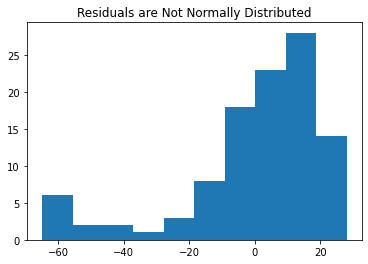

In [36]:
fig, ax = plt.subplots()
ax.hist(fsm.resid)
ax.set_title("Residuals are Not Normally Distributed")

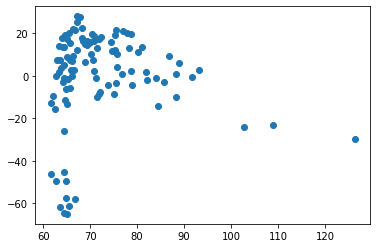

In [38]:
y_hat = fsm.predict(X_train['Student_Count_Total'])

fig, ax = plt.subplots()
ax.scatter(y_hat, fsm.resid,  )

In [39]:
from sklearn.model_selection import cross_validate

In [46]:
# With a cv of 3, we get splits with the val size exactly equal to the test set
cross_validate(LinearRegression(), X_train[['Student_Count_Total']], y_train, cv=3)

{'fit_time': array([0.00467992, 0.06809425, 0.05601907]),
 'score_time': array([0.00242615, 0.00443983, 0.00313115]),
 'test_score': array([0.21600542, 0.14084973, 0.07050349])}

In [53]:
# With a cv of 4, the r^2 becomes very unstable
cross_validate(LinearRegression(), X_train[['Student_Count_Total']], y_train, cv=4)

{'fit_time': array([0.00548792, 0.01325393, 0.00706697, 0.00219178]),
 'score_time': array([0.00276208, 0.0030551 , 0.002985  , 0.00258923]),
 'test_score': array([ 0.22327189, -0.08609349,  0.01018786, -1.15676486])}

In [54]:
# With a cv of 5, the r^2 becomes a bit more stable than 4
cross_validate(LinearRegression(), X_train[['Student_Count_Total']], y_train, cv=5)

{'fit_time': array([0.00525522, 0.00400901, 0.00288177, 0.0030911 , 0.01009679]),
 'score_time': array([0.0022769 , 0.00233793, 0.00229502, 0.00261593, 0.00347614]),
 'test_score': array([ 0.20433089,  0.14663487,  0.20404782,  0.12837997, -1.0369468 ])}

In [62]:
# I will proceed with a cv of 3

cv_fsm = cross_validate(LinearRegression(), 
                       X_train[['Student_Count_Total']], 
                       y_train, cv=3, return_train_score=True)


In [64]:
cv_fsm['train_score']

array([0.16810904, 0.18307846, 0.2055279 ])

In [63]:
# Baseline Train R^2 via cross validation
np.mean(cv_fsm['train_score'])

0.1855718004689901

In [65]:
cv_fsm['test_score']

array([0.21600542, 0.14084973, 0.07050349])

In [60]:
# Baseline Val R^2 via cross validation
np.mean(cv_fsm['test_score'])

0.1424528826778352

In [61]:
# Baseline std via cross validation
np.std(cv_fsm['test_score'])

0.059411730929310846